In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [2]:
def moving_average(a, n=10): 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret/=n
    # Masking
    ret[:n-1]=ret[n-1]
    ret=ret.reshape(-1,1)
    return ret

def read_train_patients(input_len = 8, output_len = 6):
    x_train=[]
    y_train=[]
    #y_train_f=[]
    for i in range(1, 16):
        #y_noised=[]
        
        df=pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
        dataset=df.values
        #dataset = moving_average(dataset)

        scaler = MinMaxScaler(feature_range=(0, 1)) 
        scaled_data = scaler.fit_transform(dataset)
        train_data = scaled_data
        #train_data = dataset
        
        for i in range(input_len,len(train_data)-output_len):
            x_train.append(train_data[i-input_len:i,0])
            y_train.append(train_data[i+output_len-1,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    #reshape 
    #x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    print(x_train.shape)
    print(y_train.shape)
    return scaler, x_train, y_train

In [3]:
#random forest
def train_model_RFR(x_train, y_train, n_estimators=1000):
    X_val = x_train[11000:]
    Y_val = y_train[11000:]
    X_train = x_train[:11000]
    Y_train = y_train[:11000]

    #random_forest = RandomForestRegressor(n_estimators=n_estimators,random_state=100,oob_score=True)
    #random_forest.fit(X_train, Y_train)
    
    random_forest = RandomForestRegressor()
        
    #find best hyperparams
    param_grid = {
    'n_estimators': [235, 500, 530, 525, 600],
    'max_depth': [8, 10, 12],
    'min_samples_split': [1, 2],
    'max_features': ['auto', 'sqrt'],
    }
    
    grid_cv = GridSearchCV(random_forest, param_grid=param_grid, cv=2, n_jobs=-1)
    gs_results = grid_cv.fit(X_train,Y_train)
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    
    random_forest = RandomForestRegressor(n_estimators=gs_results.best_params_['n_estimators'],random_state=0,oob_score=False)
    random_forest.fit(X_train, Y_train)
    
    """curve = pd.DataFrame(rmse_val) #elbow curve 
    print(curve)
    plt.figure(figsize=(24,16))
    plt.title('RMSE according to the Num of Neighbors(K)',fontsize=40)
    plt.plot(curve, linewidth=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel('value of K',fontsize=28)
    plt.ylabel('RMSE',fontsize=28)"""
    
    #validation
    prediction = random_forest.predict(X_val)
    r_squared = random_forest.score(X_val, Y_val)
    error = np.sqrt(mean_squared_error(Y_val,prediction))
    print('RMSE: ',error )
    
    return random_forest


In [4]:
scaler, x_train, y_train = read_train_patients()

(12750, 8)
(12750,)


In [5]:
random_forest = train_model_RFR(x_train, y_train) 

0.7705135079349135
RandomForestRegressor(max_depth=8, n_estimators=500)
{'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500}
RMSE:  0.10238290394684788


In [10]:
def show_plots(i, continuous_ytest, continuous_predictions):
    plt.figure(figsize=(24,16))
    plt.title('Blood Glucose Prediction Model Result_patient_{}'.format(i),fontsize=40)
    plt.plot(continuous_ytest, color = 'b', linewidth=4)
    plt.plot(continuous_predictions, color = 'r', ls="--", linewidth=4)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.ylim(40, 300)
    ax=plt.axes()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.xlabel('Timestamp',fontsize=28)
    plt.ylabel('BG(CGM) (mg/dL)',fontsize=28)
    plt.legend(['Real','Predictions'], loc='upper right',fontsize=32)
    plt.show()

In [7]:
def test_model(model, i, input_len=8, output_len=6):
    df = pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
    dataset=df.values
    
    #dataset = moving_average(dataset)
    
    # Scalling data from 0 - 1 to input in the neural network
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_data = scaler.fit_transform(dataset)
    
    x_test =[]
    y_test =[]
    
    continuous_ytest=[]
    i= input_len
    
    for i in range(input_len,len(dataset)-output_len):
        x_test.append(scaled_data[i-input_len:i,0])
        y_test.append(dataset[i+output_len-1,0])
        continuous_ytest.append(dataset[i+output_len-1,0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
  
    #x_test= np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    predictions = model.predict(x_test)
    print(predictions.shape)
    predictions = np.reshape(predictions,(1,-1))
    predictions = scaler.inverse_transform(predictions)
    print(predictions)
    print(y_test)
    #print("predictions: ", predictions)
    
    continuous_predictions = predictions[0]
    for i in range(1, len(predictions)):
        continuous_predictions = np.concatenate([continuous_predictions, predictions[i]])
    
    #print(predictions)
    #print(y_test)
    
    
    rmse=np.sqrt(np.mean(((predictions[0]-y_test)**2)))
    mape=np.mean(np.abs((predictions[0]-y_test)/y_test)*100)
    
    return rmse, mape, continuous_ytest, continuous_predictions

(850,)
[[131.13122241 132.44869511 120.98116151 118.28856299 114.21974451
  116.13088625 112.66368401 109.81008965 104.62400684 105.27138442
  102.11294891 105.64622324  95.89668583 101.89336949 114.80304597
  116.93849648 111.70625692 116.51286282 111.06736578 119.11581661
  122.33440349 133.73569651 137.06701484 137.16968435 127.30556979
  127.2209905  129.3195171  121.33302594 121.50161297 132.82128495
  135.98516438 140.5261385  142.9503621  156.21637497 144.49168938
  138.85692028 122.17029694 121.92058334 125.73276136 122.81002263
  119.31457267 107.51089477 108.85668831 104.42118752 109.90663535
  112.33703298 115.57490137 118.01835543 120.64505989 127.94149894
  132.42673816 134.51454168 124.20155755 119.54736717 120.44281166
  114.38722347 114.82549812 114.54536593 118.7649635  137.11144781
  152.52879568 146.16152581 122.33206597 119.01985503 120.5672532
  135.9312809  129.38048561 128.66718687 137.97072942 137.73533506
  125.54096481 125.14333085 117.04768758 116.99648416 11

<ipython-input-10-756d3b346d75>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


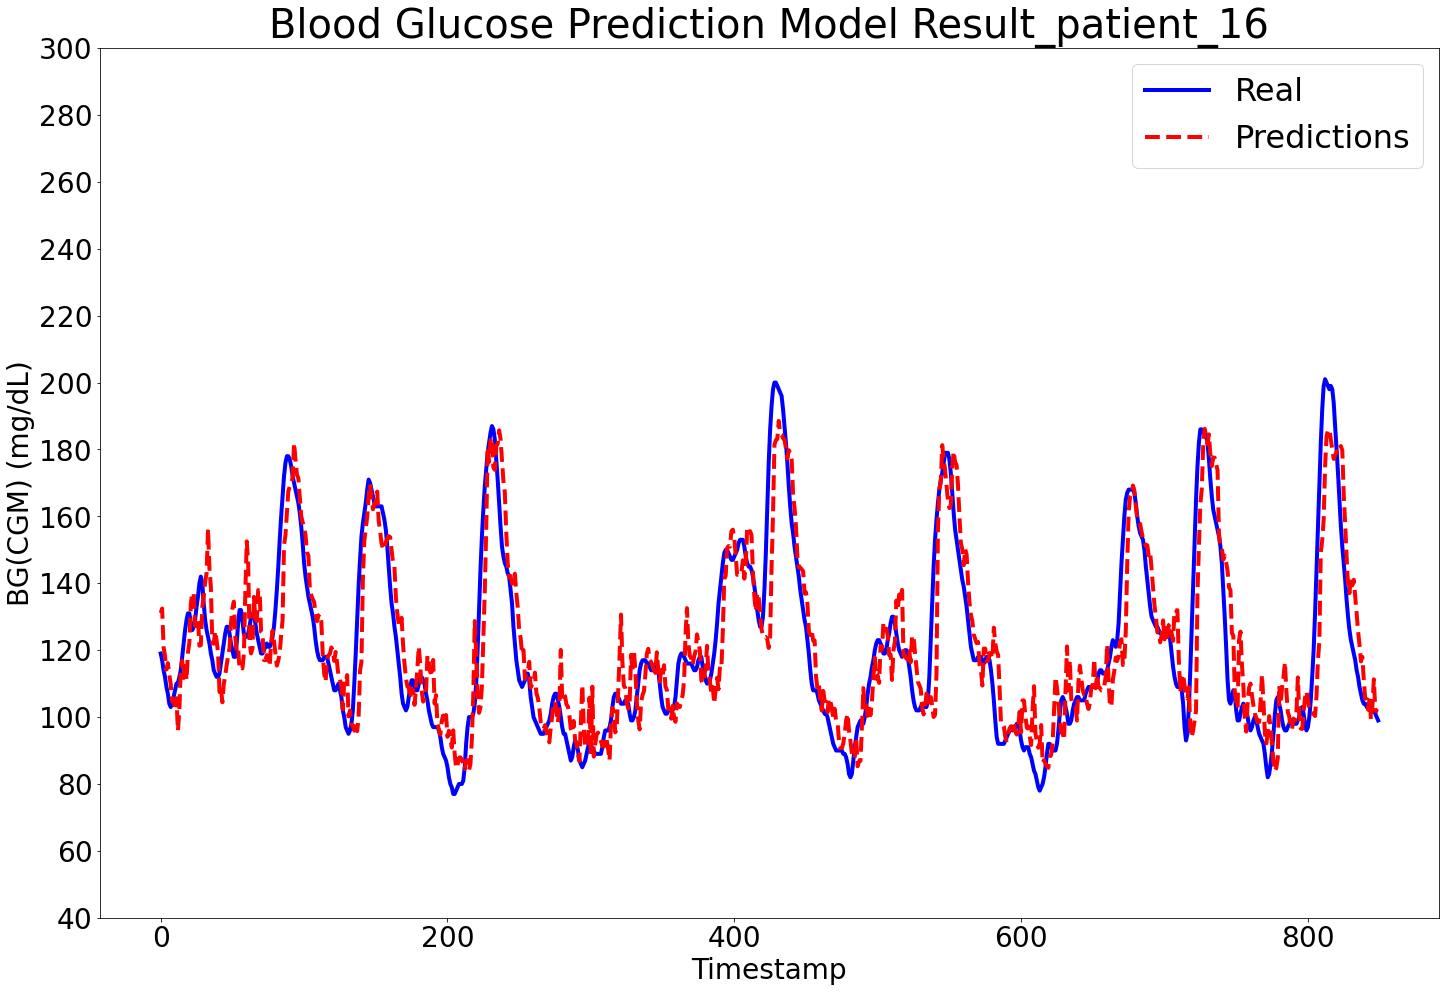

0.9114053240384933
0.9446685795519449
0.9665065051131102
0.9730016256664134
Time_delay(min):  20
Root-Mean-Squared Deviation 13.672915115895368
Mean-Absolute-Percentage-Error 8.175902848419682
(850,)
[[109.43242602 109.36953803 111.50315882 111.05588864 107.91955771
  108.08645876 108.04823367 109.26982819 107.54383917 110.2100184
  105.24496502 118.13413013 132.20162078 116.22276839 117.65019237
  115.46436875 116.09777388 108.90288554 112.62811716 107.18863733
  113.76109795 121.27224479 122.24676298 119.42408752 115.83661203
  113.76283585 114.84668927 112.68165147 111.98580189 114.48879585
  110.89013777 107.86636999 117.31218096 110.19831898 111.75180929
  110.27788803 107.26998871 110.11698705 109.71427287 104.39135976
  106.04643624 116.99648555 106.64835995 105.83257771 105.34076575
  105.10857086 103.94532404 104.95587136 106.44537297 100.39941424
   98.39660609  97.36793801  97.70347815  99.66309969 130.26276923
  141.4608177  125.11912026 129.2817742  120.76653054 114.967861

<ipython-input-10-756d3b346d75>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


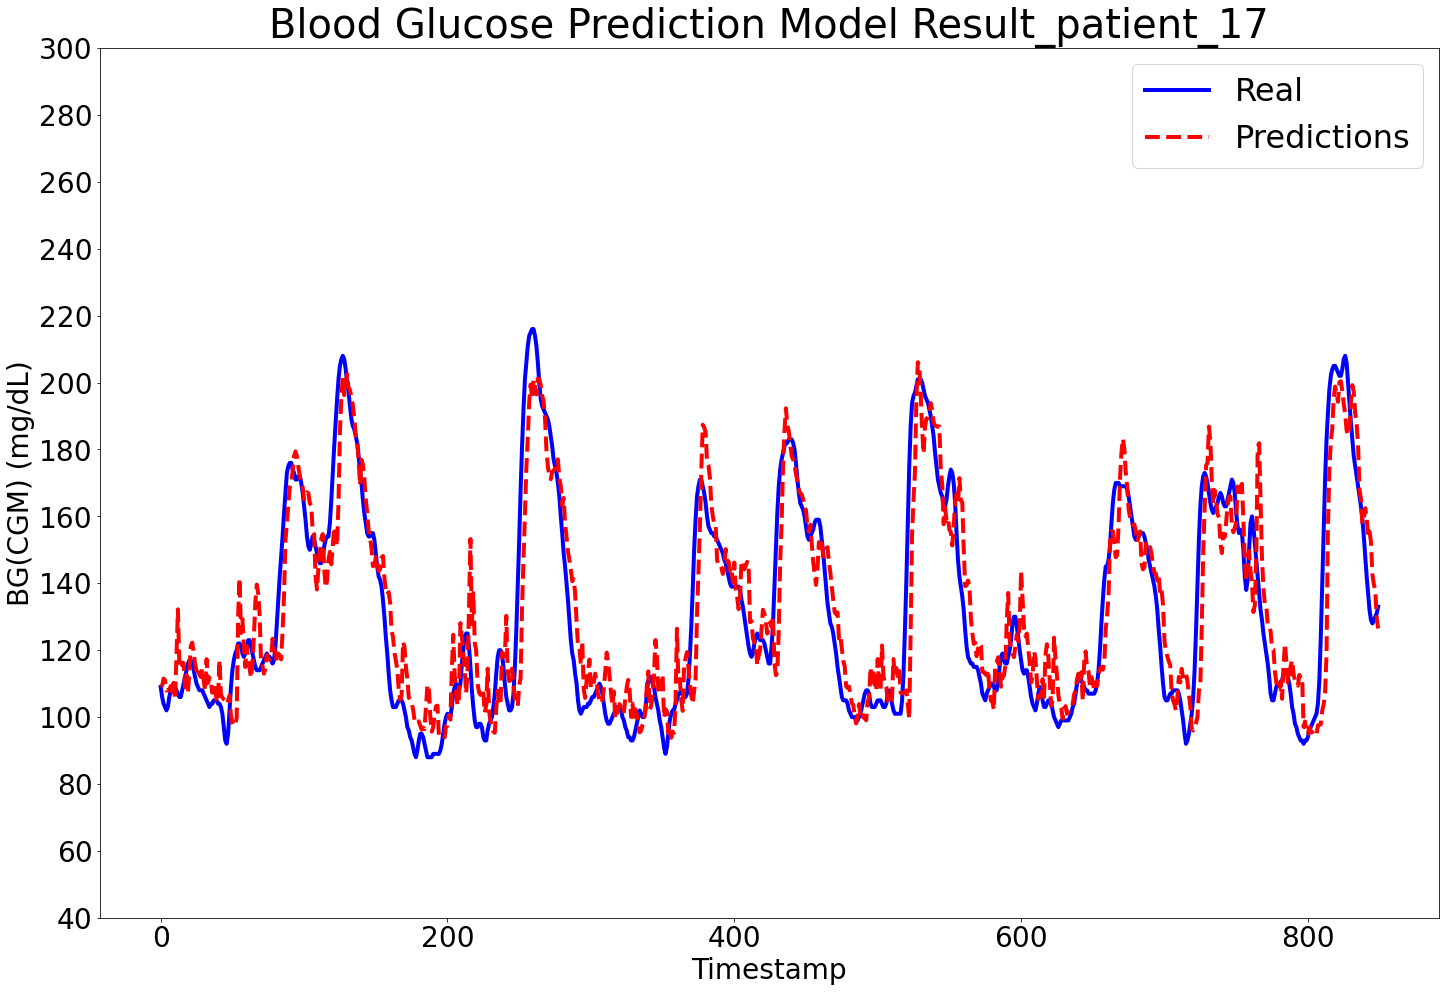

0.9293901828811951
0.955044249473154
0.971817671005627
0.9766667809285864
Time_delay(min):  20
Root-Mean-Squared Deviation 14.370051899946445
Mean-Absolute-Percentage-Error 8.009379445275158
(850,)
[[136.63232447 137.3400864  139.40541459 137.73062066 138.99537526
  140.56182426 129.63826402 128.77867008 129.21778126 129.65262423
  125.10811403 127.32711012 128.12637866 117.01504145 112.87119809
  111.81500785 108.95353608 109.87697318 115.08193541 121.63080178
  130.1736571  133.68127492 125.23221508 125.8701901  130.58340845
  124.58871889 124.30067626 123.86675382 123.87833644 131.09083465
  132.62984419 132.97226803 127.37236261 134.55611893 129.13051979
  128.49624807 125.11291316 128.46826251 131.21969318 128.69647608
  124.29950916 125.70925096 120.87262316 115.70961875 107.8012693
  105.68816855 103.63361709 112.39975646 118.67730291 116.82916296
  115.25466332 113.8923958  108.68089502 110.50847612 108.95813385
  108.82983686 111.49186388 109.27250128 120.42933143 119.0602574


<ipython-input-10-756d3b346d75>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


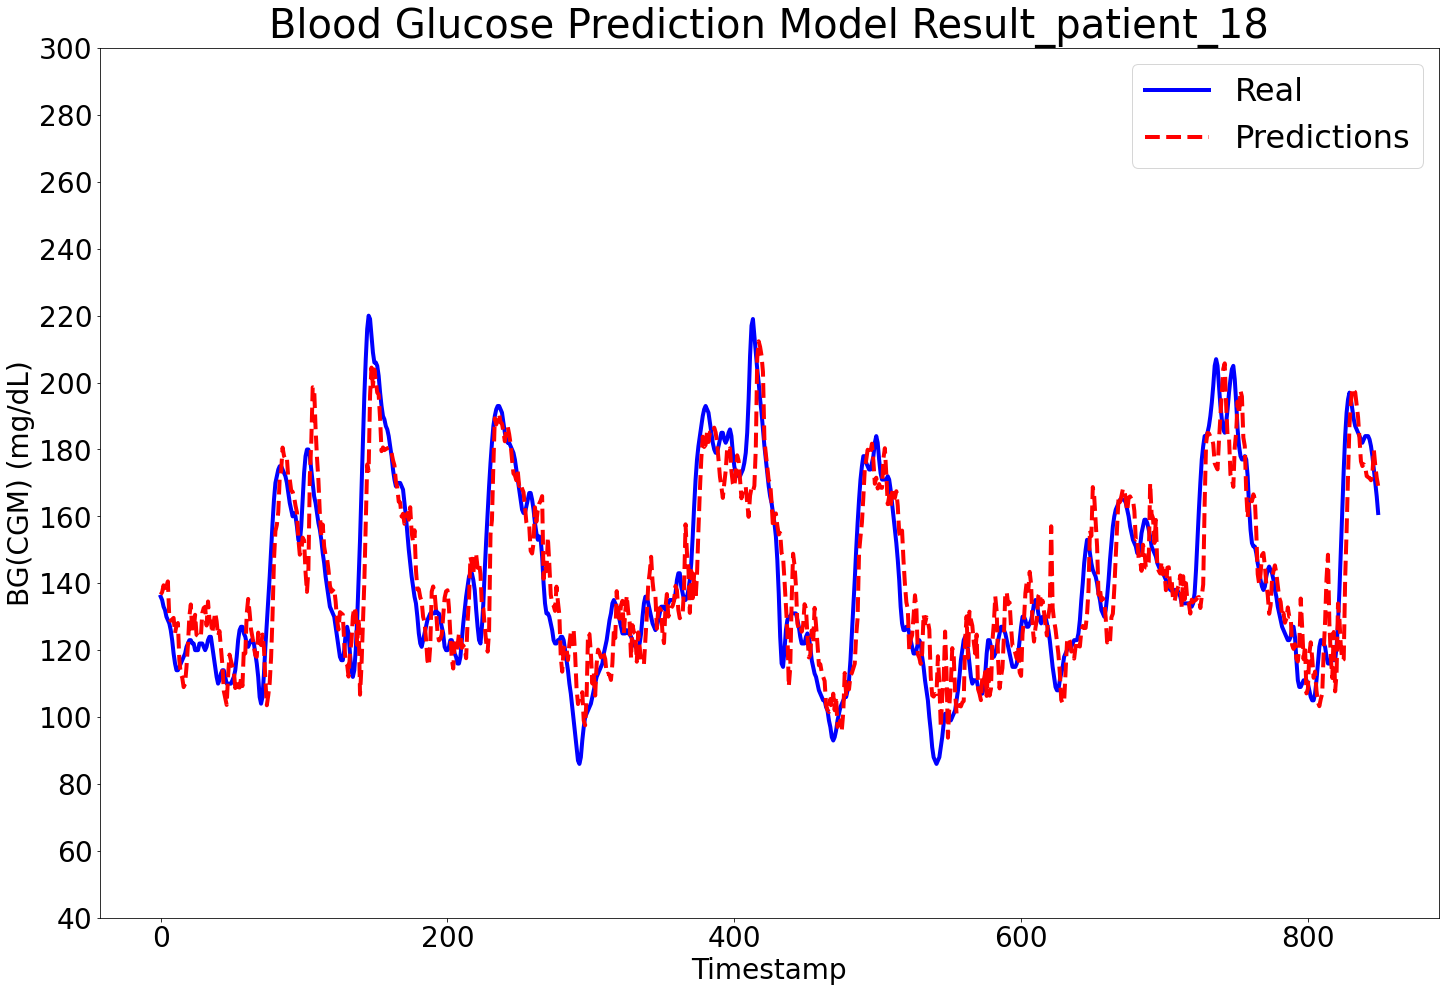

0.9092171703549208
0.9364772492312308
0.9559853754949882
0.9632263492568853
Time_delay(min):  20
Root-Mean-Squared Deviation 13.777497686384008
Mean-Absolute-Percentage-Error 7.360371762708011
(850,)
[[103.29098481 105.0548309  116.4027596  110.20355727 103.74510987
  103.09019891 103.79556756 103.32118035 110.07107968 107.63413318
  107.98102132 105.23681233  92.96423819  93.86018851  94.15757348
  107.79739771 116.08339547 121.44984492 128.53306111 127.21366327
  123.96637359 111.62839474 109.14525464 112.4921059  108.34677816
  111.70864454 108.87876179 106.80227263 105.44816694 115.44978928
  115.97289734 114.79739912 115.69400122 113.35491726 117.51086138
  120.89729603 124.22692976 123.74211317 137.15223405 129.41106715
  135.65219255 149.44295087 157.56841732 146.97245403 136.57546044
  128.24240903 122.33142657 130.29316875 124.75819848 125.56142701
  123.548463   122.39312189 122.31158638 134.86820294 146.16521111
  140.12468749 141.22334481 130.70051647 123.74683145 124.11128

<ipython-input-10-756d3b346d75>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


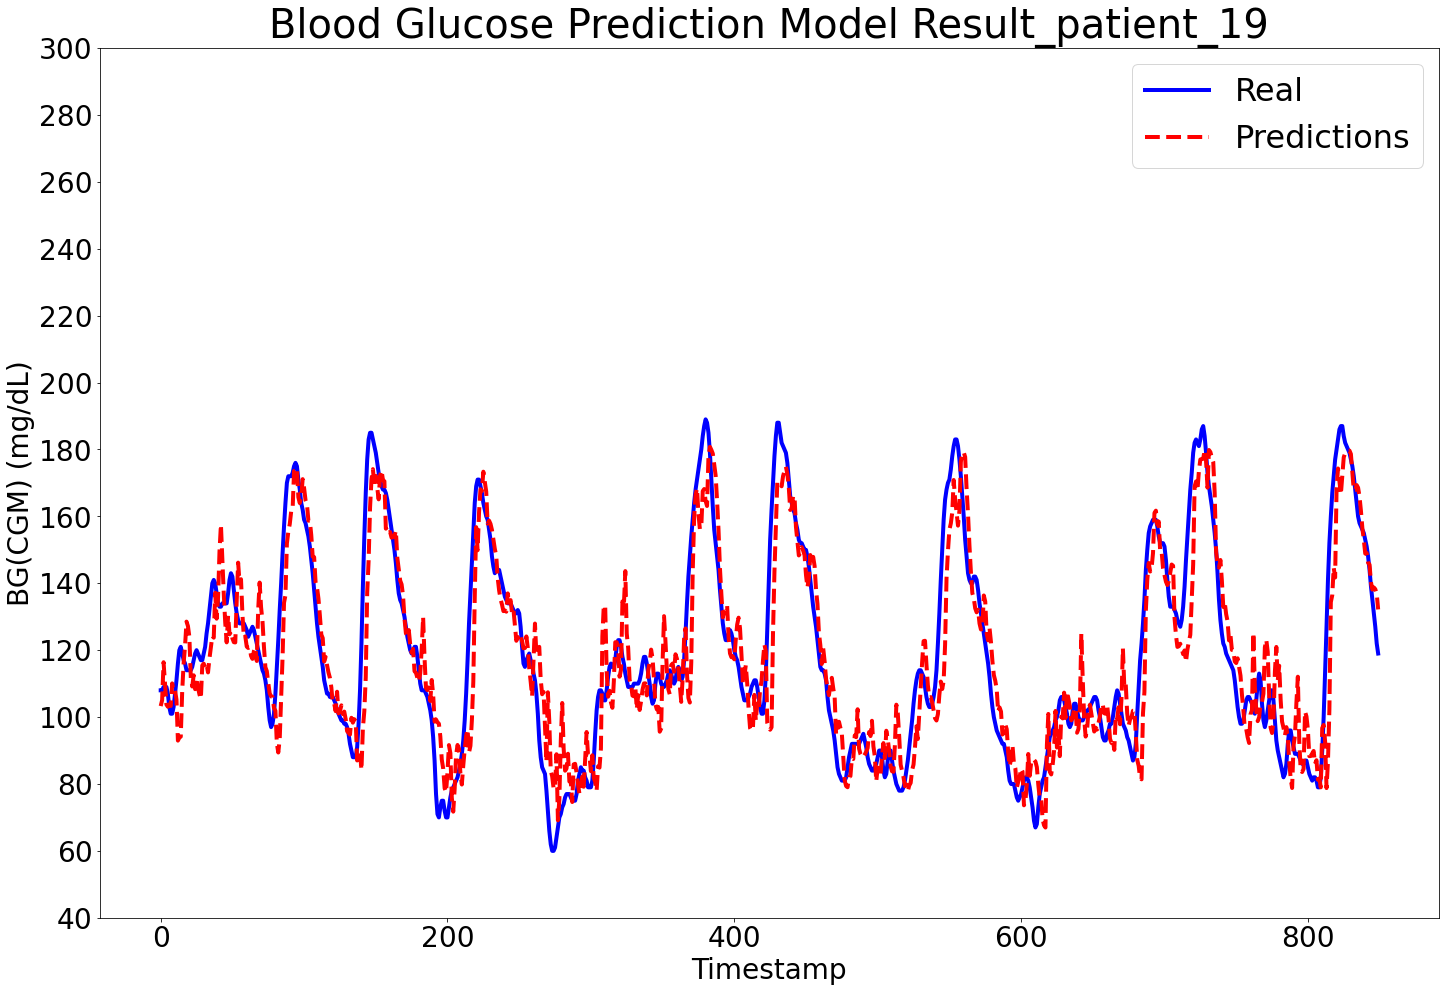

0.9226421535959822
0.948657471205548
0.9657060316965941
0.9706307524198997
Time_delay(min):  20
Root-Mean-Squared Deviation 14.18177443309894
Mean-Absolute-Percentage-Error 9.125835858689898
(850,)
[[113.58456813 115.95748917 116.17491968 116.31564168 115.329835
  126.28350663 142.65647248 140.77868938 132.91631853 119.22860209
  118.98549677 122.93564013 120.25163839 114.93125714 109.78434301
  108.98765527 103.87004344 103.45004502 102.02913301 105.14584795
  100.2992223   96.2494307  103.30231911 113.99371193 115.48153853
  113.86909985 104.98801597  95.20667169  96.3781691  102.70003126
  109.27828003 108.75570936 112.05380285 114.72756161 115.78543778
  126.09851301 120.33375636 118.41199868 122.38034189 119.9729288
  124.47926394 129.93330091 133.98637833 131.46226598 125.43095854
  121.84727287 122.99523798 114.41292217 109.73372451 105.28063095
  110.84442314 107.6496791  106.70913058  98.13154836  94.4481788
  100.89807675 104.40731163 104.22886167 114.29619225 108.12713596
  

<ipython-input-10-756d3b346d75>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


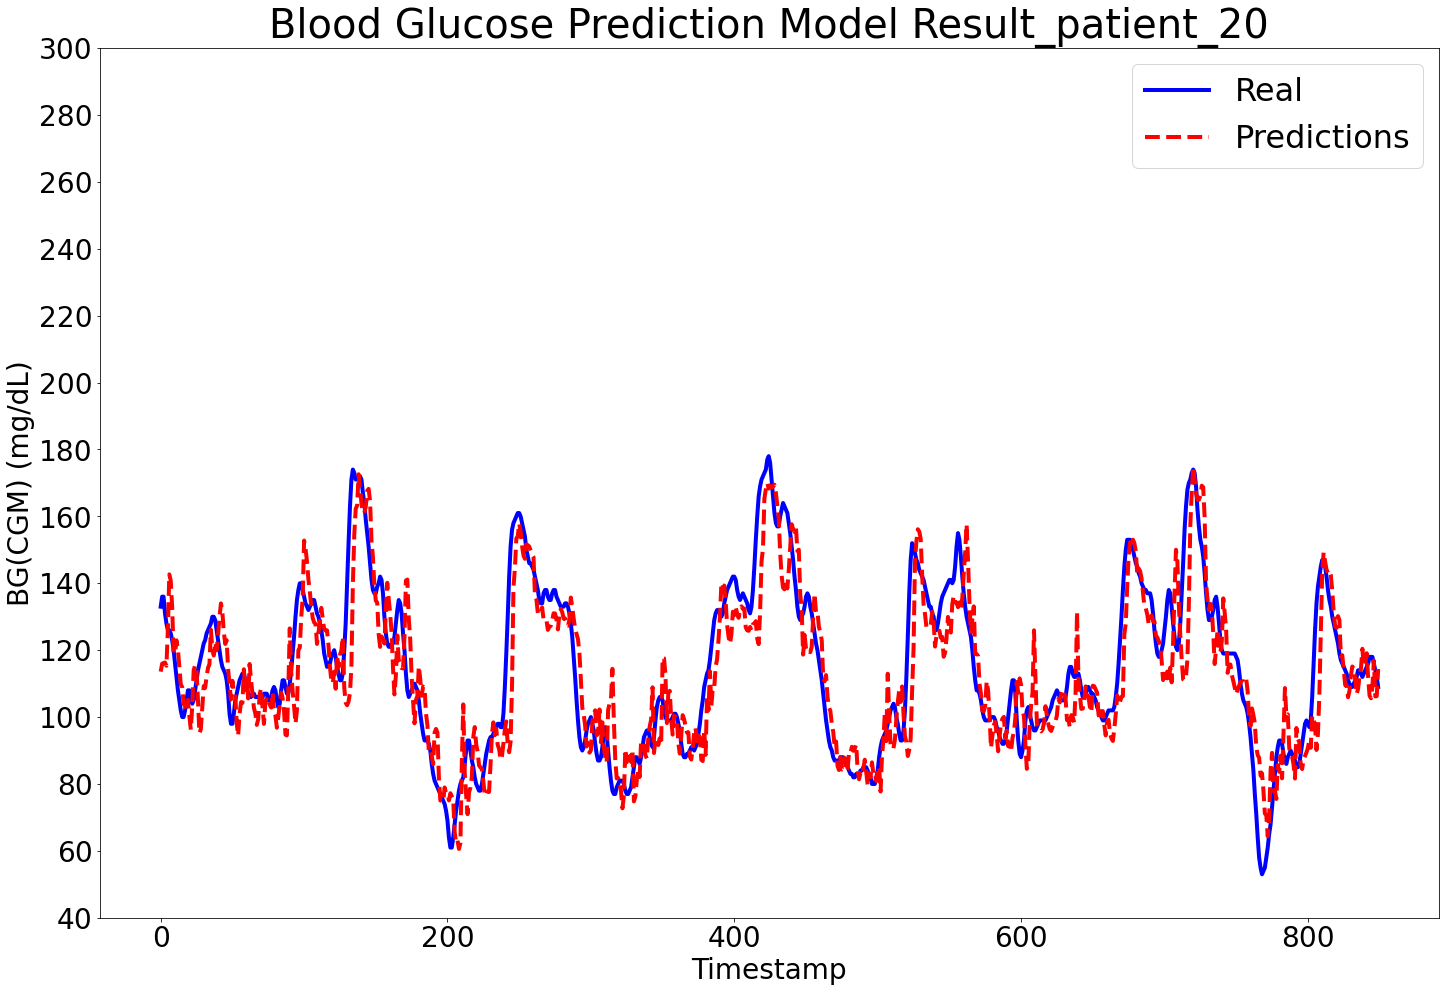

0.8905753588907802
0.9240802665001968
0.9497059417173037
0.9623852731862368
Time_delay(min):  20
Root-Mean-Squared Deviation 13.108796043349694
Mean-Absolute-Percentage-Error 8.501208853190452


In [11]:
def get_time_gain(continuous_ytest, continuous_predictions):
    corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6:-6])[0,1]
    max_corr = corr
    #j=1
    max_trans = 0
    for j in range(1, 6):
        trans_corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6+j:-6+j])[0,1] 
        if max_corr < trans_corr:
            max_corr = trans_corr
            print(max_corr)
            max_trans = j
    return max_trans
    

for i in range(16,21):
    rmse, mape, continuous_ytest, continuous_predictions = test_model(random_forest, i)
    show_plots(i, continuous_ytest, continuous_predictions)
    time_gain = get_time_gain(continuous_ytest, continuous_predictions)
    print("Time_delay(min): ", time_gain*5)
    print("Root-Mean-Squared Deviation {}".format(rmse))
    print("Mean-Absolute-Percentage-Error {}".format(mape))